In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time


### Problem 10

In [4]:
Brain = load_data("BrainCancer")
Brain.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

<Axes: xlabel='timeline'>

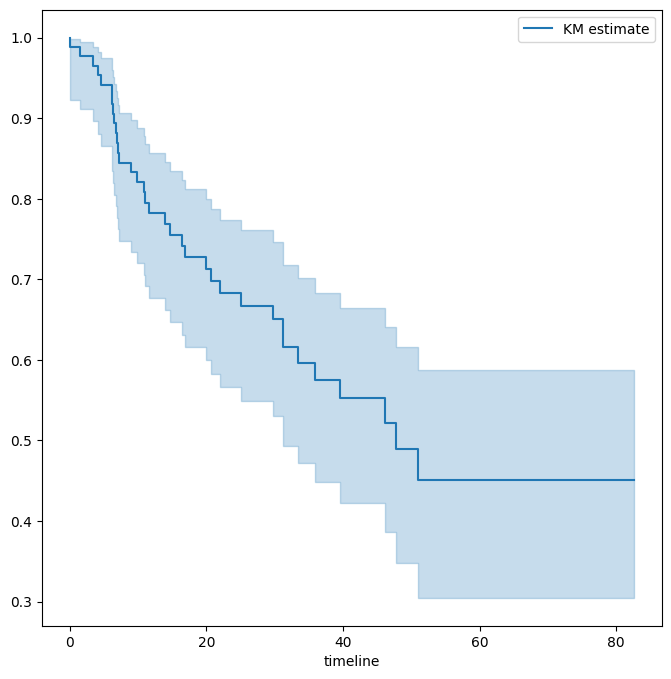

In [5]:
fig, ax  = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(Brain['time'], Brain['status'])
km_brain.plot(label = 'KM estimate', ax = ax)

In [23]:
ci = km_brain.confidence_interval_
est = km_brain.survival_function_
se = (ci.iloc[:,1] - est.iloc[:,0]) / 1.96
se

0.00     0.000000
0.07     0.004977
1.18     0.004977
1.41     0.008721
1.54     0.008721
           ...   
65.02    0.069303
67.38    0.069303
73.74    0.069303
78.75    0.069303
82.56    0.069303
Length: 87, dtype: float64

In [24]:
def boot_choice(df, time_grid):
    km = KaplanMeierFitter()
    boot_km = km.fit(df['time'], df['status'])
    surv = boot_km.predict(time_grid)
    return surv

def boot_sample(df, n = 88, B = 200):
    rng = np.random.default_rng(0)

    time_grid = km.fit(df['time'], df['status']).survival_function_.index
    survival_curves = []

    for _ in range(B):
        idx = rng.choice(df.index, n, replace = True)
        choice = df.loc[idx]
        
        boot_surv = boot_choice(choice, time_grid)
        survival_curves.append(boot_surv)
    
    df_surv = pd.concat(survival_curves, axis = 1)
    se = df_surv.std(axis =1)

    return se, df_surv

se_boot, df_boot = boot_sample(Brain)        
    


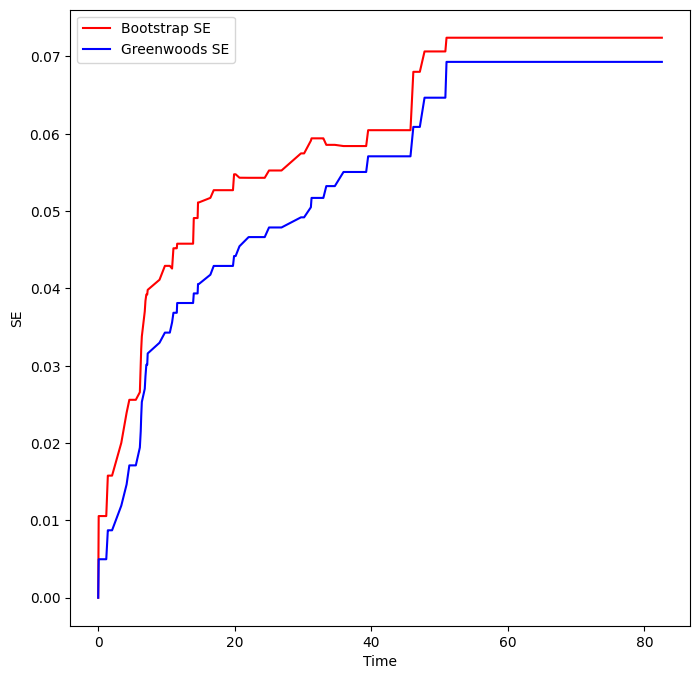

In [30]:
fig, ax  = subplots(figsize = (8,8))
ax.plot(se_boot, color = 'red')
ax.plot(se, color ='blue')
ax.set_xlabel("Time")
ax.set_ylabel("SE")
ax.legend(labels = ["Bootstrap SE", 'Greenwoods SE'])


In [53]:
coxph = CoxPHFitter()
clean = Brain.dropna()
all =  MS(clean.columns, intercept=False)
all_vars =all.fit_transform(clean)
cox_fit = coxph.fit(all_vars, 'time', 'status')
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


In [54]:
clean['ki'] = clean['ki'].replace({40:60})

levels = clean['ki'].unique()

def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
    

modal_data = clean.apply(representative, axis=0)

modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['ki'] = levels
modal_df



C:\Users\campz\AppData\Local\Temp\ipykernel_12472\3212333084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['ki'] = clean['ki'].replace({40:60})


,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,90,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,70,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,80,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,100,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,60,8.687011,SRT,0.402299,27.188621


In [ ]:
modal_X = all.transform(modal_df)
modal_X.index = levels
modal_X

,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
90,0.0,0.0,1.0,0.0,1.0,90,8.687011,1.0,0.402299,27.188621
70,0.0,0.0,1.0,0.0,1.0,70,8.687011,1.0,0.402299,27.188621
80,0.0,0.0,1.0,0.0,1.0,80,8.687011,1.0,0.402299,27.188621
100,0.0,0.0,1.0,0.0,1.0,100,8.687011,1.0,0.402299,27.188621
60,0.0,0.0,1.0,0.0,1.0,60,8.687011,1.0,0.402299,27.188621


In [56]:

predicted_survival = cox_fit.predict_survival_function(modal_X)
predicted_survival


,90,70,80,100,60
0.07,0.998753,0.996261,0.997840,0.999280,0.993532
1.18,0.998753,0.996261,0.997840,0.999280,0.993532
1.41,0.997374,0.992140,0.995455,0.998484,0.986421
1.54,0.997374,0.992140,0.995455,0.998484,0.986421
2.03,0.997374,0.992140,0.995455,0.998484,0.986421
...,...,...,...,...,...
65.02,0.797428,0.506907,0.675589,0.877517,0.308173
67.38,0.797428,0.506907,0.675589,0.877517,0.308173
73.74,0.797428,0.506907,0.675589,0.877517,0.308173
78.75,0.797428,0.506907,0.675589,0.877517,0.308173


<Axes: >

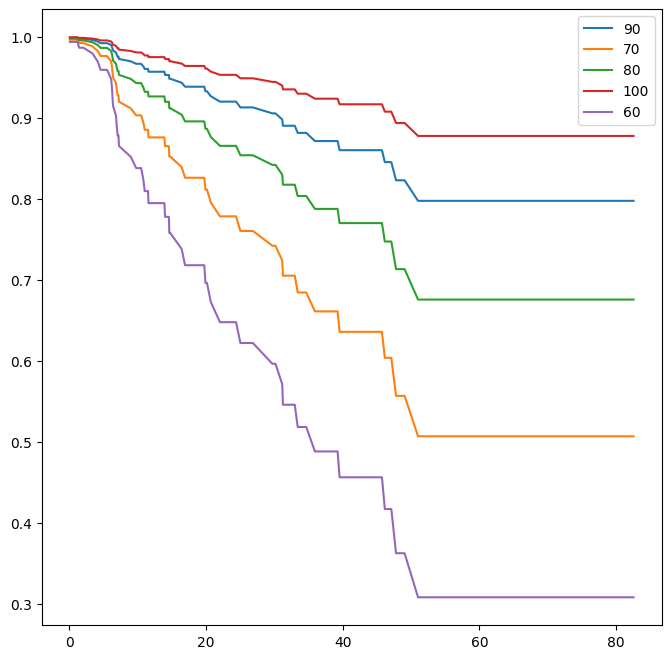

In [57]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax)

### Problem 11

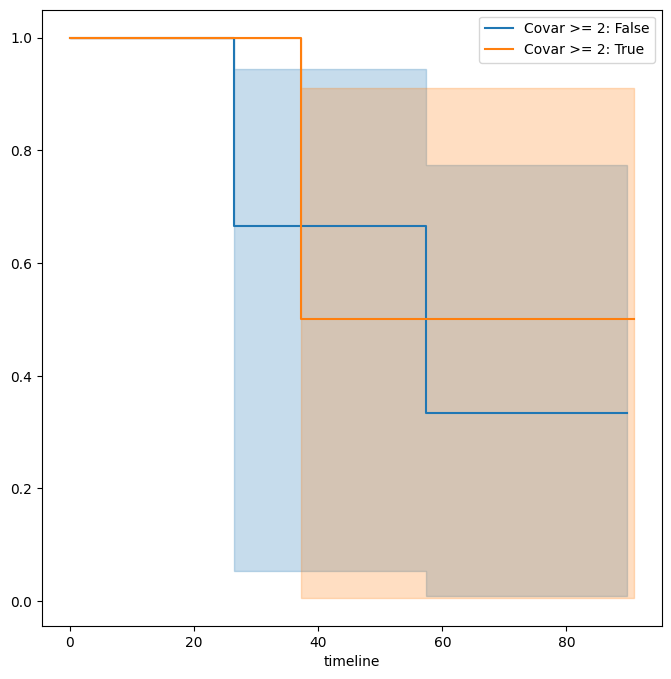

In [82]:
df_11 = pd.DataFrame({"Obs": np.array([26.5, 37.2, 57.3, 90.8, 20.2, 89.8]), 
                      'delta': np.array([1,1,1,0,0,0]), 
                      'Covar': np.array([0.1, 11, -0.3, 2.8, 1.8, 1.4])})

cond = df_11['Covar'] >= 2


fig, ax = subplots(figsize=(8,8))

# This is your boolean Series:
cond = df_11['Covar'] >= 2

by_cov = {}

for cov, df in df_11.groupby(cond):
    by_cov[cov] = df

    km_sex = KaplanMeierFitter()
    km_sex.fit(df["Obs"], df["delta"], label=f"Covar >= 2: {cov}")
    km_sex.plot(ax=ax)


In [87]:
df_11["Group"] = (cond).astype(int)

model_df = MS(df_11.columns.drop("Covar"), intercept=False).fit_transform(df_11)
cox = coxph.fit(model_df, 'Obs', 'delta')
cox.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
Group,-0.340143,1.235876,0.783144


In [88]:
cox.log_likelihood_ratio_test()


<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.08 0.78      0.36

In [89]:
logrank_test(df_11["Obs"].loc[df_11["Group"] == 1],
             df_11["Obs"].loc[df_11["Group"] == 0],
             df_11["delta"].loc[df_11["Group"] == 1],
             df_11["delta"].loc[df_11["Group"] == 0])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.08 0.78      0.35